In [ ]:
import numpy as np
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess

from utils import get_figure, time_plot, arma_theoretical_spectral_density, plot_fft, moving_average_smoothing
from data.x_data import get_sea_surface_temp


### Exercise 
Compare different tapering windows, their properties and use cases.<br>
• How energy spreads around peaks.<br>
• How frequencies are attenuated.<br>

Compare different linear filters, their properties and use cases.<br>

Evaluate the effect of tapering, smoothing, filtering on your real-world data.<br>
• Review the spectrum in log scale.<br>
• Apply different tapering windows.<br>
• Determine appropriate smoothing strength.<br>
• Review the effect of different filters.<br>

### Comparing tapering windows

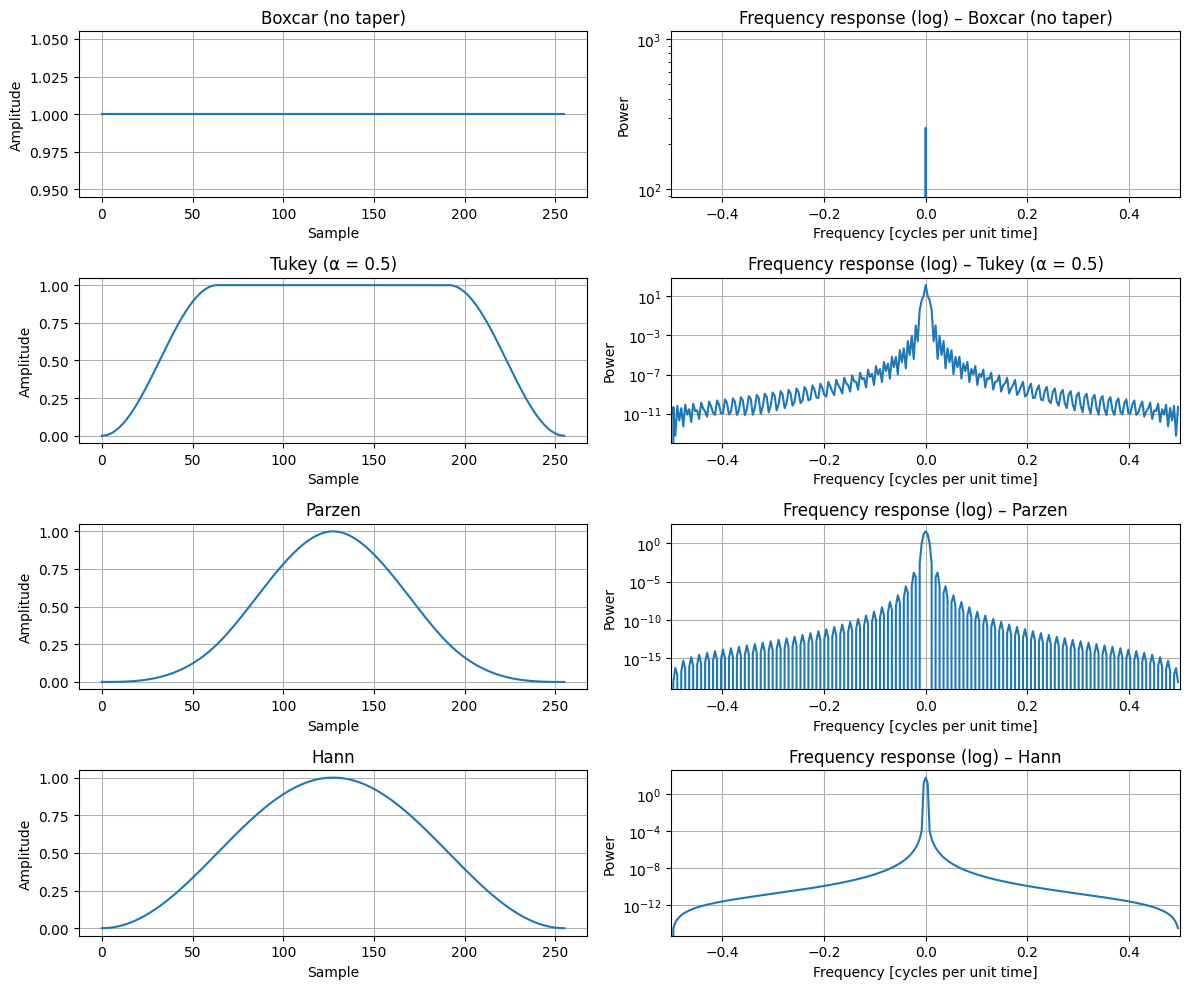

In [3]:
import matplotlib.pyplot as plt

n = 256
t = np.arange(n)

windows = [
    ("Boxcar (no taper)", np.ones(n)),
    ("Tukey (α = 0.5)", signal.windows.tukey(n, alpha=0.5)),
    ("Parzen", signal.windows.parzen(n)),
    ("Hann", signal.windows.hann(n)),
]

fig, axs = get_figure(nrows=len(windows), ncols=2, figsize=(12, 10))

for i, (name, w) in enumerate(windows):
    # Time-domain window
    time_plot(
        t,
        w,
        title=name,
        xlabel="Sample",
        ylabel="Amplitude",
        ax=axs[2*i],
    )
    
    
    W = np.fft.fftshift(np.fft.fft(w))
    freqs = np.fft.fftshift(np.fft.fftfreq(n, d=1))
    power = np.abs(W)**2 / n

    axs[2*i + 1].plot(freqs, power)
    axs[2*i + 1].set_yscale("log")
    axs[2*i + 1].set_xlim(-0.5, 0.5)
    axs[2*i + 1].set_title(f"Frequency response (log) – {name}")
    axs[2*i + 1].set_xlabel("Frequency [cycles per unit time]")
    axs[2*i + 1].set_ylabel("Power")

fig.tight_layout()


**Boxcar (no taper)**  
- Sharp edges in time cause strong spectral leakage.  
- Energy spreads far around the main peaks because sidelobes are large.  
- Gives the best frequency resolution, but the worst leakage.  
- Only suitable if the signal fits perfectly into the time window.  

**Tukey window (α = 0.5)**  
- Smooths the signal at the edges while keeping the middle flat.  
- Reduces leakage compared to the boxcar window.  
- Balances frequency resolution and leakage reduction.  
- Useful when some tapering is needed without losing too much detail.  

**Parzen window**  
- Very smooth taper with strong leakage reduction.  
- Energy is well concentrated, but peaks become much wider.  
- Best when leakage matters more than precise frequency reminder.  

**Hann window**  
- Smooth taper at both ends of the signal.  
- Strongly reduces leakage and limits energy spread around peaks.  
- Peaks become slightly wider, so frequency resolution is lower.  
- Well suited for general spectral analysis of real data.  

**Energy spreading and frequency attenuation**
- Windows with sharp edges (boxcar) spread energy across many frequencies.  
- Smoother windows (Hann, Parzen) keep energy closer to the true frequency.  
- Less leakage means wider peaks and some loss of nearby frequencies.



### Comparing linear filter: high-pass filter and low-pass filter

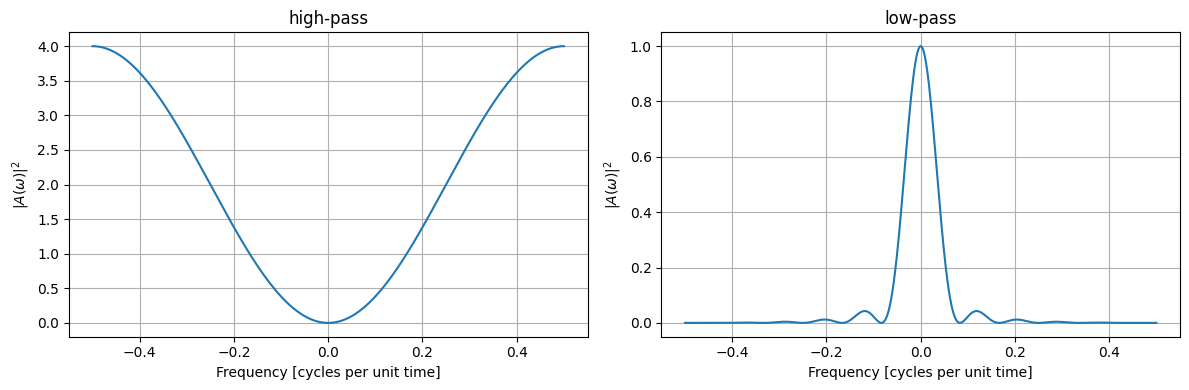

In [4]:

frequencies = np.linspace(-0.5, 0.5, 1000)

# high-pass
A2_diff = 2 * (1 - np.cos(2 * np.pi * frequencies))  # |A(ω)|^2 from slide 24

fig, axs = get_figure(nrows=1, ncols=2, figsize=(12, 4))

time_plot(
    frequencies,
    A2_diff,
    title="high-pass",
    xlabel="Frequency [cycles per unit time]",
    ylabel=r"$|A(\omega)|^2$",
    ax=axs[0],
)

# low-pass
A = (1 + np.cos(12 * np.pi * frequencies) +
     2 * sum(np.cos(2 * np.pi * frequencies * k) for k in range(1, 6))) / 12
A2_daniell = A**2

time_plot(
    frequencies,
    A2_daniell,
    title="low-pass",
    xlabel="Frequency [cycles per unit time]",
    ylabel=r"$|A(\omega)|^2$",
    ax=axs[1],
)

fig.tight_layout()


**High-pass filter (first difference)**  
- Removes low-frequency components like trends.  
- Emphasizes fast changes and short-term variation.  
- Useful for studying rapid fluctuations, but long-term structure is lost.  

**Low-pass filter (Daniell smoothing kernel)**  
- Removes high-frequency noise.  
- Keeps slow and seasonal changes.  
- Useful for studying long-term behavior. 

### Sea surface temperarture - effect of different tapering window

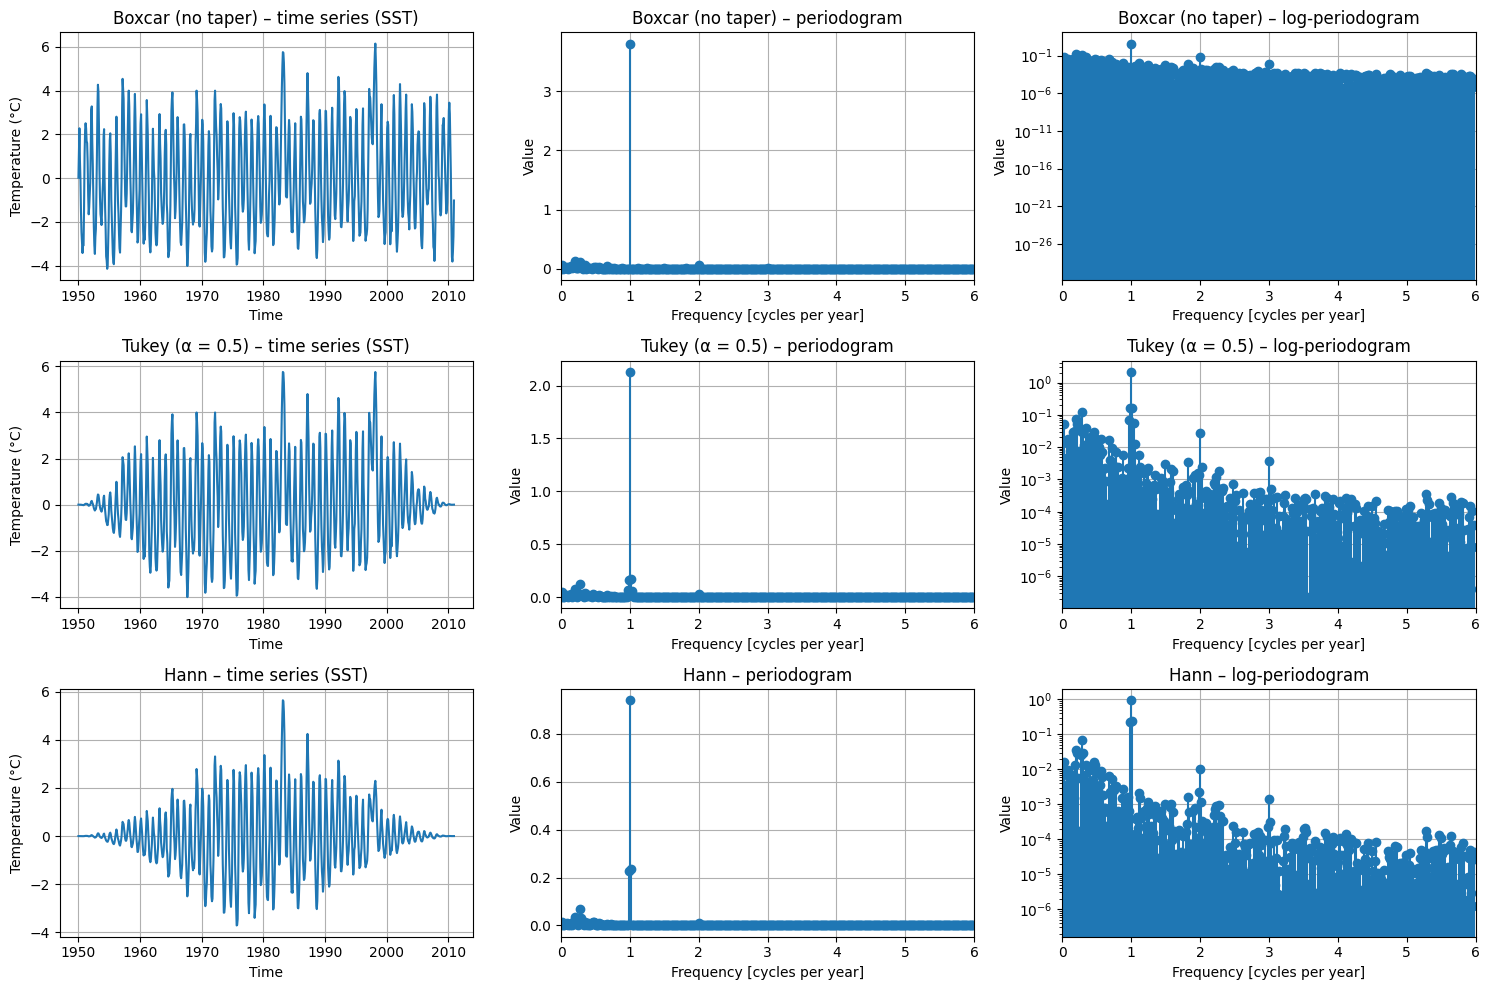

In [7]:

sst_df = get_sea_surface_temp().set_index("DATE").sort_index()
sst = sst_df["value"].asfreq("MS")
sst = sst - sst.mean()

windows = [
    ("Boxcar (no taper)", np.ones(len(sst))),
    ("Tukey (α = 0.5)", signal.windows.tukey(len(sst), alpha=0.5)),
    ("Hann", signal.windows.hann(len(sst))),
]

fig, axs = get_figure(nrows=len(windows), ncols=3, figsize=(15, 10))

for i, (name, w) in enumerate(windows):
    tapered = sst * w

    # Time plot
    time_plot(
        x=sst.index,
        y=tapered,
        title=f"{name} – time series (SST)",
        xlabel="Time",
        ylabel="Temperature (°C)",
        ax=axs[3*i],
    )

    # Periodogram (linear scale)
    plot_fft(
        axs[3*i + 1],
        tapered,
        sample_spacing=1/12,            # 12 obs per year
        sample_spacing_name="year",
        periodogram=True,
    )
    axs[3*i + 1].set_title(f"{name} – periodogram")
    axs[3*i + 1].set_xlim(0, 6)        # cycles per year

    # Periodogram (log scale)
    plot_fft(
        axs[3*i + 2],
        tapered,
        sample_spacing=1/12,
        sample_spacing_name="year",
        periodogram=True,
        log_scale=True,
    )
    axs[3*i + 2].set_title(f"{name} – log-periodogram")
    axs[3*i + 2].set_xlim(0, 6)

fig.tight_layout()


- Tapering reduces leakage in the SST spectrum, clearly visible in the log scale.  
- Hann and Tukey windows give cleaner peaks than the boxcar window, especially at the yearly frequency.  
- Stronger tapering slightly lowers power and widens peaks but improves clarity. 

### Sea surface temperature – smoothed periodogram

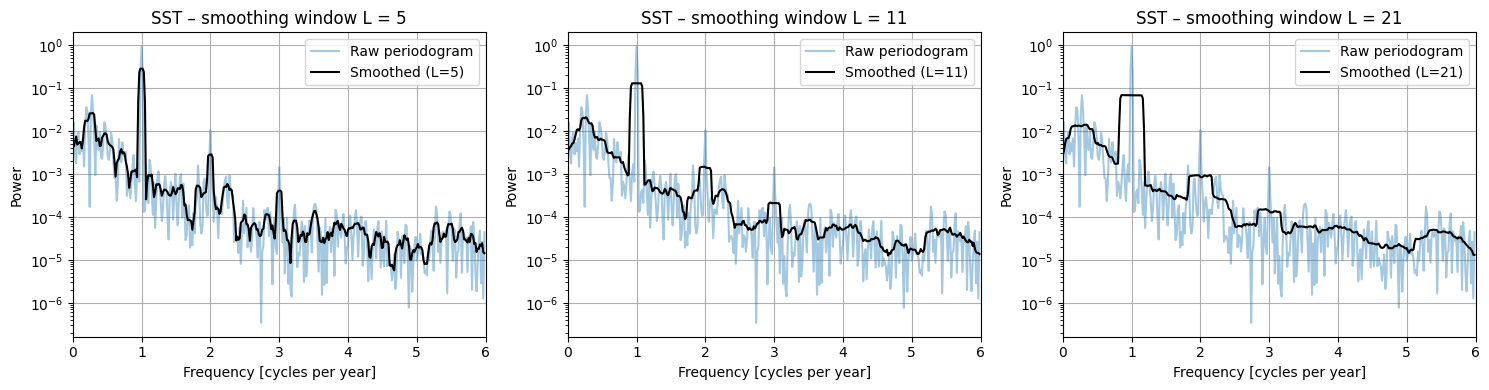

In [ ]:
# Hann-taper 
w_hann = signal.windows.hann(len(sst))
sst_tapered = sst * w_hann

def sst_smoothed_periodogram(series, window_size):
    fig_dummy, [ax_dummy] = get_figure()  
    xf, _, P = plot_fft(
        ax_dummy,
        series,
        sample_spacing=1/12,
        sample_spacing_name="year",
        periodogram=True,
        return_fft=True,
    )
    plt.close(fig_dummy)  

    _, _, P_smooth = moving_average_smoothing(P, window_size=window_size, mode="same")
    return xf, P, P_smooth

window_sizes = [5, 11, 21]  
fig, axs = get_figure(nrows=1, ncols=3, figsize=(15, 4))

for ax, wsize in zip(axs, window_sizes):
    xf, P_raw, P_s = sst_smoothed_periodogram(sst_tapered, window_size=wsize)
    ax.plot(xf, P_raw, alpha=0.4, label="Raw periodogram")
    ax.plot(xf, P_s, color="black", label=f"Smoothed (L={wsize})")
    ax.set_xlim(0, 6)
    ax.set_yscale("log")
    ax.set_title(f"SST – smoothing window L = {wsize}")
    ax.set_xlabel("Frequency [cycles per year]")
    ax.set_ylabel("Power")
    ax.legend()

fig.tight_layout()


- **Window L = 5**: Little smoothing, spectrum still noisy.  
- **Window L = 11**: Good balance between smoothness and visible peaks.  
- **Window L = 21**: Very smooth spectrum, but peaks become less sharp.  

Larger smoothing windows reduce noise but blur spectral peaks.  

### Sea surface temperature – effect of linear filters

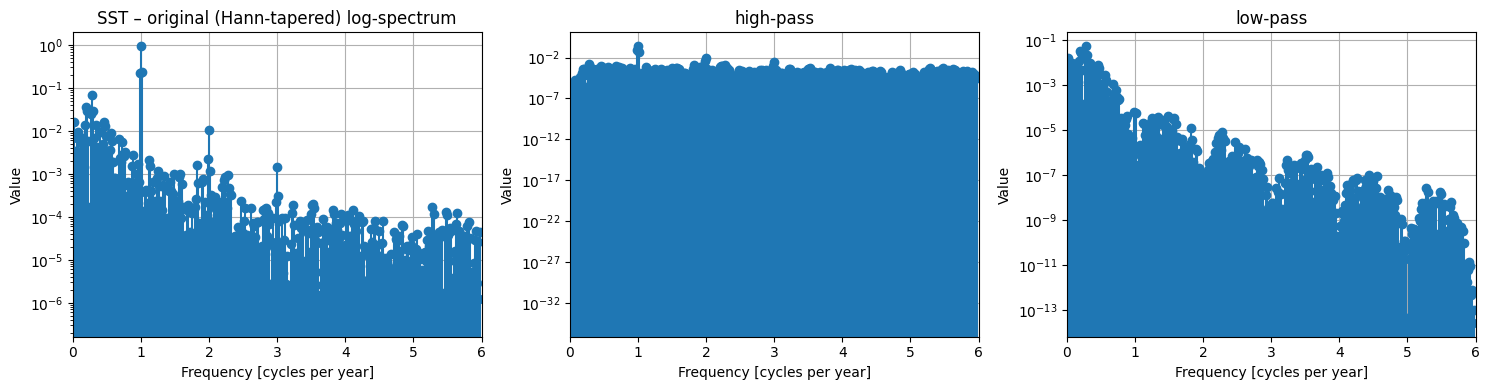

In [ ]:
import pandas as pd
orig = sst_tapered

# high-pass
diff_series = orig.diff().dropna()

# modified kernel with m = 6
# symmetric weights of length 2m+1 = 13
a = np.zeros(13)
a[0] = a[-1] = 1/24         
a[1:-1] = 1/12               
# keep same length
daniell_values = np.convolve(orig.values, a, mode="same")
daniell_series = pd.Series(daniell_values, index=orig.index)

fig, axs = get_figure(nrows=1, ncols=3, figsize=(15, 4))

plot_fft(
    axs[0],
    orig,
    sample_spacing=1/12,
    sample_spacing_name="year",
    periodogram=True,
    log_scale=True,
)
axs[0].set_title("SST – original (Hann-tapered) log-spectrum")
axs[0].set_xlim(0, 6)

# high-pass
plot_fft(
    axs[1],
    diff_series,
    sample_spacing=1/12,
    sample_spacing_name="year",
    periodogram=True,
    log_scale=True,
)
axs[1].set_title("high-pass")
axs[1].set_xlim(0, 6)

# low-pass
plot_fft(
    axs[2],
    daniell_series,
    sample_spacing=1/12,
    sample_spacing_name="year",
    periodogram=True,
    log_scale=True,
)
axs[2].set_title("low-pass")
axs[2].set_xlim(0, 6)

fig.tight_layout()


- High-pass filtering removes slow changes and highlights short-term variation.  
- Low-pass filtering removes fast noise and keeps slow and seasonal patterns.  
- In the log spectrum, this appears as reduced power in selected frequency ranges.  